# Reorder Prediction Using a CatBoost Ensemble Model

In [1]:
#Import Relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None


from sklearn.model_selection import train_test_split
from sklearn.metrics import *


#import utility functions from script
from utils import *
from modeling_utils import *

#Data file directory
root = 'C:/Users/ALEXANDER/Documents/Machine Learning/Instacart/Data/'

##Ignore Warning
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_pickle(root + 'final_dataset.pkl')
id_segment = pd.read_csv("id_segment_map.csv")
#reduce memory allocation
data = reduce_memory(data)

Memory usage of properties dataframe is : 3620.7658081054688  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1301.2127122879028  MB
This is  35.9375 % of the initial size


In [3]:
#New feature generation
data['order_diff'] = data['order_number'] - data['last_ordered_in']
data.drop(['product_id'], axis = 1, inplace = True)
data.head()

,user_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,mean_add_to_cart_order,total_orders,total_reorders,reorder_percentage,unique_users,order_first_time_total_cnt,order_second_time_total_cnt,is_organic,second_time_percent,aisle_mean_add_to_cart_order,aisle_std_add_to_cart_order,aisle_total_orders,aisle_total_reorders,aisle_reorder_percentage,aisle_unique_users,aisle,department_mean_add_to_cart_order,department_std_add_to_cart_order,department_total_orders,department_total_reorders,department_reorder_percentage,department_unique_users,department,avg_dow,std_dow,avg_doh,std_doh,avg_since_order,std_since_order,total_orders_by_user,total_products_by_user,total_unique_product_by_user,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,1,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0,3.722656,35791,27791.0,0.776367,8000,8000,4660,0,0.582520,6.453125,6.449219,357537,228406.0,0.638672,63506,soft drinks,6.976562,6.710938,2690129,1757892.0,0.653320,172795,beverages,2.644531,1.255859,10.539062,3.5,18.546875,10.5625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0,4.277344,1946,1389.0,0.713867,557,557,308,0,0.552734,9.320312,7.906250,306487,159119.0,0.519043,76177,nuts seeds dried fruit,9.187500,7.691406,2887550,1657973.0,0.574219,174219,snacks,2.644531,1.255859,10.539062,3.5,18.546875,10.5625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
2,1,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,8.0,14.0,0.0,4.191406,5526,3603.0,0.651855,1923,1923,1003,0,0.521484,7.144531,6.281250,3642188,2615469.0,0.718262,177141,fresh fruits,8.023438,6.660156,9479291,6160710.0,0.649902,193237,produce,2.644531,1.255859,10.539062,3.5,18.546875,10.5625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,6.0
3,1,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,0.0,4.761719,6476,4797.0,0.740723,1679,1679,889,0,0.529297,8.460938,7.375000,163524,96804.0,0.591797,44854,popcorn jerky,9.187500,7.691406,2887550,1657973.0,0.574219,174219,snacks,2.644531,1.255859,10.539062,3.5,18.546875,10.5625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
4,1,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14.0,1.0,5.621094,3751,2465.0,0.657227,1286,1286,617,0,0.479736,9.046875,7.566406,377586,215822.0,0.571777,77080,cereal,9.125000,7.601562,709569,398013.0,0.561035,114169,breakfast,2.644531,1.255859,10.539062,3.5,18.546875,10.5625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0


In [4]:
#Chech dataset size
data.shape

(8474661, 58)

In [5]:
#Get numerical columns
num_cols = data._get_numeric_data().columns
#GEt categorical columns
cat_cols = list(set(data.columns) - set(num_cols))

In [6]:
data = data.merge(id_segment, on = 'user_id', how = 'left')

- **After finding the possible cohort (clusters) among the different customers, I decided to substitute each user_id with the cluster to which they are assumed to belong. Hope this would eventually increase the predictive model performance.**

- By performing Iterative Feature selection, I deduced that these sets of features are useless. Hence I decided to drop them.

In [7]:
data.drop(["department_unique_users","order_first_time_total_cnt","department_total_reorders","department_std_add_to_cart_order",
"aisle_unique_users","total_orders_by_user","aisle_total_reorders","is_reorder_3","total_orders_by_user","user_id"],1,inplace=True)

In [8]:
#seperate target and predictors
Target = data['reordered']
data_features = data.drop(['reordered'],1)

In [9]:
#Split data into Train and test set
Train, Test, y_train, y_test = train_test_split(data_features,Target, stratify=Target, random_state=21,shuffle=True,
                                               train_size=0.85)

- Due to the size of all categories in `aisle` and `department`. `One hot encoding` and `label encoding` would not be ideal. So I decided to try `target encoding`.

In [10]:
#Encode categorical features
TE_encoder = TargetEncoder()
a = Train[cat_cols]
b = Test[cat_cols]

X_target_encoded = TE_encoder.fit(a,y_train)
Train =X_target_encoded.transform(Train)
Test = X_target_encoded.transform(Test)

In [11]:
#Check distribution of targets
print(f"Train reorder distribution [0: {np.bincount(y_train)[0]}], [1: {np.bincount(y_train)[1]}]")
print(f"Test reorder distribution [0: {np.bincount(y_test)[0]}], [1: {np.bincount(y_test)[1]}]")

Train reorder distribution [0: 6498961], [1: 704500]
Test reorder distribution [0: 1146876], [1: 124324]


In [13]:
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [16]:
catboost =  CatBoostClassifier(random_seed=10,use_best_model=True,l2_leaf_reg=9.5,max_depth=10,
                               bagging_temperature=1,
                          n_estimators=3500,silent=True,eval_metric='Logloss')

catboost.fit(Train,y_train,eval_set=[(Train,y_train)],early_stopping_rounds=100,
                           verbose=250,use_best_model=True)
predictions = catboost.predict_proba(Test)[:,1]

0:	learn: 0.6570655	test: 0.6569382	best: 0.6569382 (0)	total: 12.2s	remaining: 11h 49m 46s
250:	learn: 0.2448812	test: 0.2449272	best: 0.2449272 (250)	total: 27m 34s	remaining: 5h 56m 53s
500:	learn: 0.2429769	test: 0.2430169	best: 0.2430169 (500)	total: 53m 52s	remaining: 5h 22m 29s
750:	learn: 0.2413847	test: 0.2414241	best: 0.2414241 (750)	total: 1h 20m 18s	remaining: 4h 53m 56s
1000:	learn: 0.2400700	test: 0.2401090	best: 0.2401090 (1000)	total: 1h 46m 21s	remaining: 4h 25m 30s
1250:	learn: 0.2388971	test: 0.2389375	best: 0.2389375 (1250)	total: 2h 12m 11s	remaining: 3h 57m 38s
1500:	learn: 0.2378081	test: 0.2378494	best: 0.2378494 (1500)	total: 2h 38m 42s	remaining: 3h 31m 21s
1750:	learn: 0.2367968	test: 0.2368379	best: 0.2368379 (1750)	total: 3h 4m 24s	remaining: 3h 4m 11s
2000:	learn: 0.2358029	test: 0.2358444	best: 0.2358444 (2000)	total: 3h 31m 21s	remaining: 2h 38m 19s
2250:	learn: 0.2348284	test: 0.2348698	best: 0.2348698 (2250)	total: 3h 57m 7s	remaining: 2h 11m 34s
2500:

In [46]:

def evaluation_report(y_test, predictions,pred_prob):
    print ("\n Classification report : \n",classification_report(y_test, predictions))
    print (f"Accuracy Score : {accuracy_score(y_test, predictions)}")
    print(f"Weighted F1 Score: {f1_score(y_test, predictions,average='weighted')}")
    print (f"Area under curve : {roc_auc_score(y_test,pred_prob)}\n")
    print (f"Logloss score : {log_loss(y_test,pred_prob)}\n")


def plot_confusion(conf_matrix):
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='YlOrBr')
    limit1, limit2 = plt.ylim()
    plt.ylim(limit1 + 0.5, limit2 - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.savefig("Confusion_Matrix.png",bbox_inches="tight")

    
def plot_roc_curve(y_true,pred_prob):

    fpr,tpr,thresholds = roc_curve(y_true,pred_prob)
    norm = np.sqrt(tpr * (1-fpr))
    index = np.argmax(norm)
    threshold = np.round(thresholds[index],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %roc_auc_score(y_test,pred_prob))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[index], tpr[index], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.savefig("ROC_Curve.png",bbox_inches="tight")
    plt.show()
    
def plot_feature_importance(estimator,top_n):
    fig, ax = plt.subplots(figsize = (10,15))
    sorted_idx = catboost.feature_importances_.argsort()[:top_n]
    ax.barh(Train.columns[sorted_idx], catboost.feature_importances_[sorted_idx])
    plt.xlabel("CatBoost Feature Importance")
    plt.title(f"Top {top_n} features and their importance")
    fig.savefig('CatBoost Feature Importance Plot.png',bbox_inches="tight")

### Optimize F1 score
- The goal here is to find the optimal threshold to define class boundaries in predicted probabilities.
- Here, I will make use of the precision-recall trade-off to find the optimal threshold that yields the greatest F1 score.

In [26]:
def get_results(predictions,threshold):
    pred_=[]
    for pred in predictions:
        if pred < threshold:
            pred_.append(0)
        else:
            pred_.append(1)
    return pred_

#define the threshold space
thresholds = np.arange(0.1,1.0,0.05)
results={}
precision,recall,f1 =[],[],[]
#obtain the class label predicted for each probability threshold
for threshold  in thresholds:
    results[f"{threshold}"] = get_results(predictions,threshold)
    
#Get precision,f1_score and recall at each threshold.
for thresh in results.keys():
    precision.append(precision_score(y_test,results[thresh]))
    recall.append(recall_score(y_test,results[thresh]))
    f1.append(f1_score(y_test,results[thresh],average="weighted"))

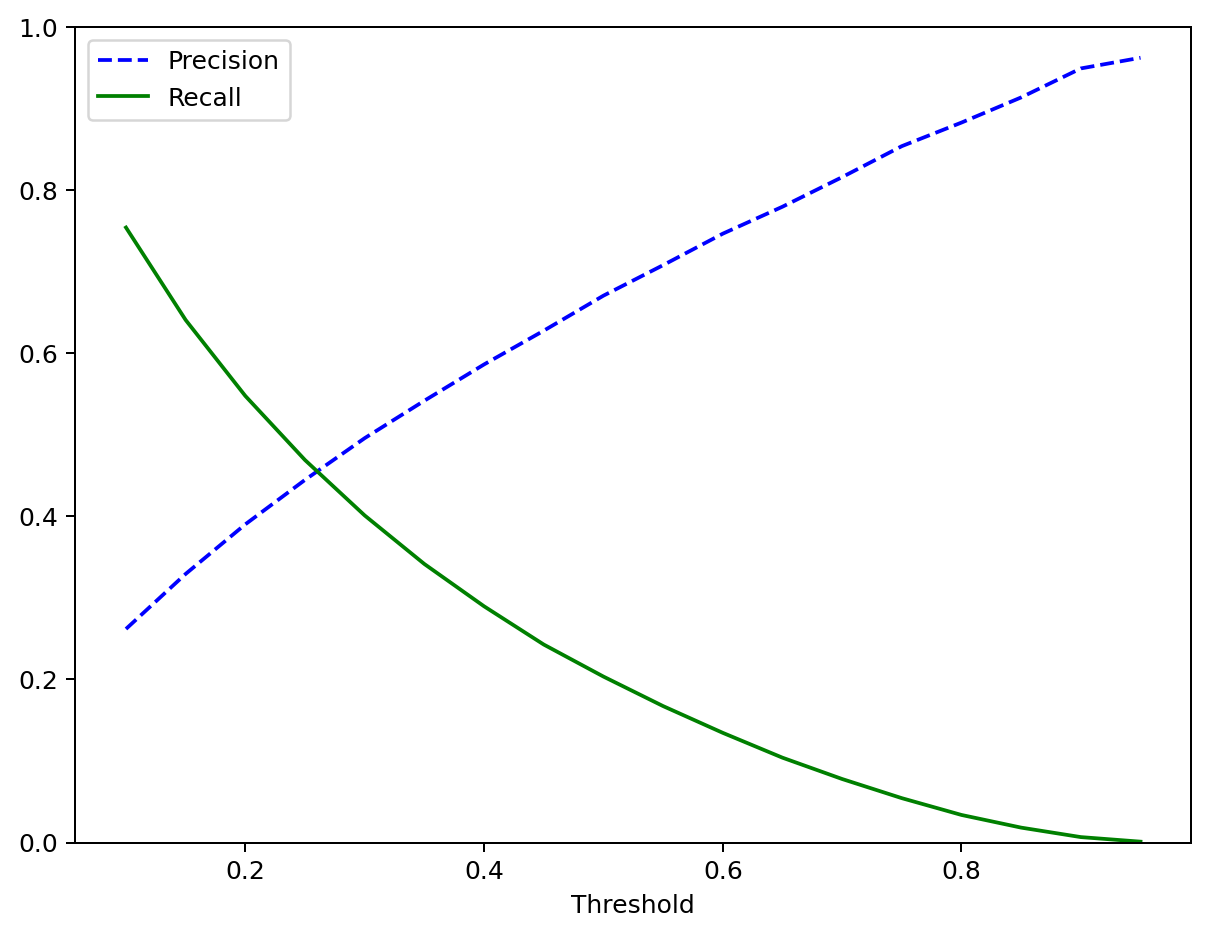

In [27]:
#plot recall vs precision to get optimal threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [28]:
print(f"The optimal probability threshold is {thresholds[np.argmax(f1)]:.2f} and the corresponding f1 score is {f1[np.argmax(f1)]}")

The optimal probability threshold is 0.35 and the corresponding f1 score is 0.8977624329393258


In [34]:
pred_=[]
threshold = 0.35
for pred in predictions:
    if pred < threshold:
        pred_.append(0)
    else:
        pred_.append(1)

conf_matrix = confusion_matrix(y_test,pred_)


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95   1146876
         1.0       0.54      0.34      0.42    124324

    accuracy                           0.91   1271200
   macro avg       0.74      0.66      0.68   1271200
weighted avg       0.89      0.91      0.90   1271200

Accuracy Score : 0.9073544682190057
Weighted F1 Score: 0.8977624329393258
Area under curve : 0.8428488481132919

Logloss score : 0.23922647310184267



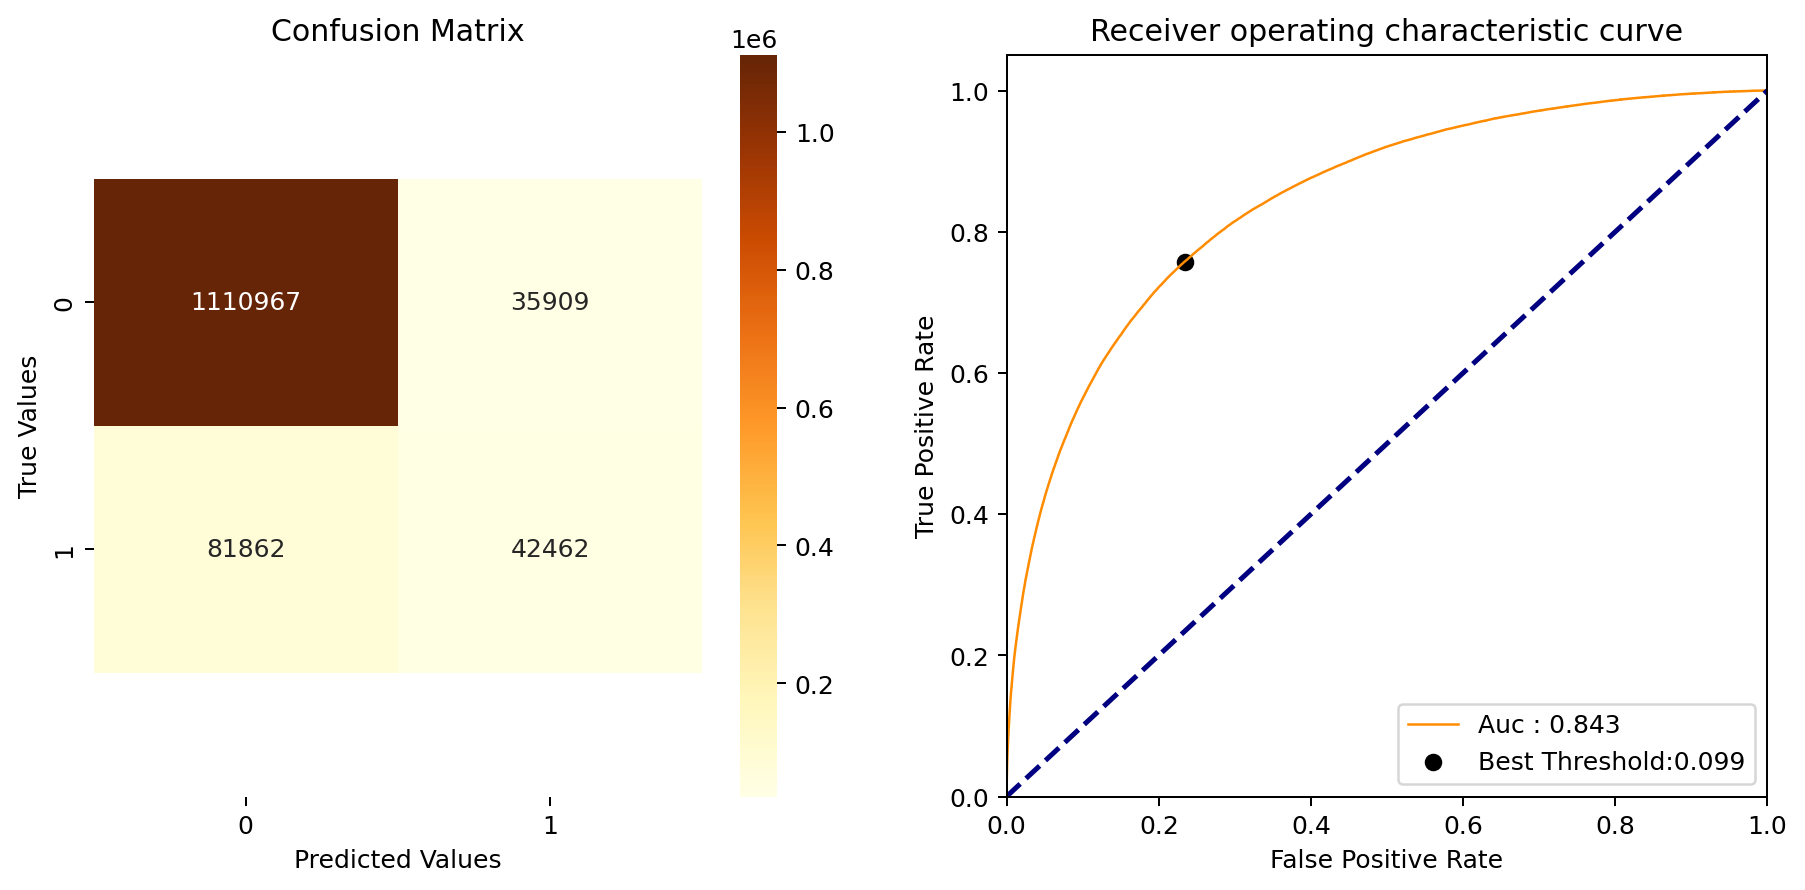

In [40]:
evaluation_report(y_test, pred_,predictions)
plot_confusion(conf_matrix)
plot_roc_curve(y_test,pred_prob=predictions)


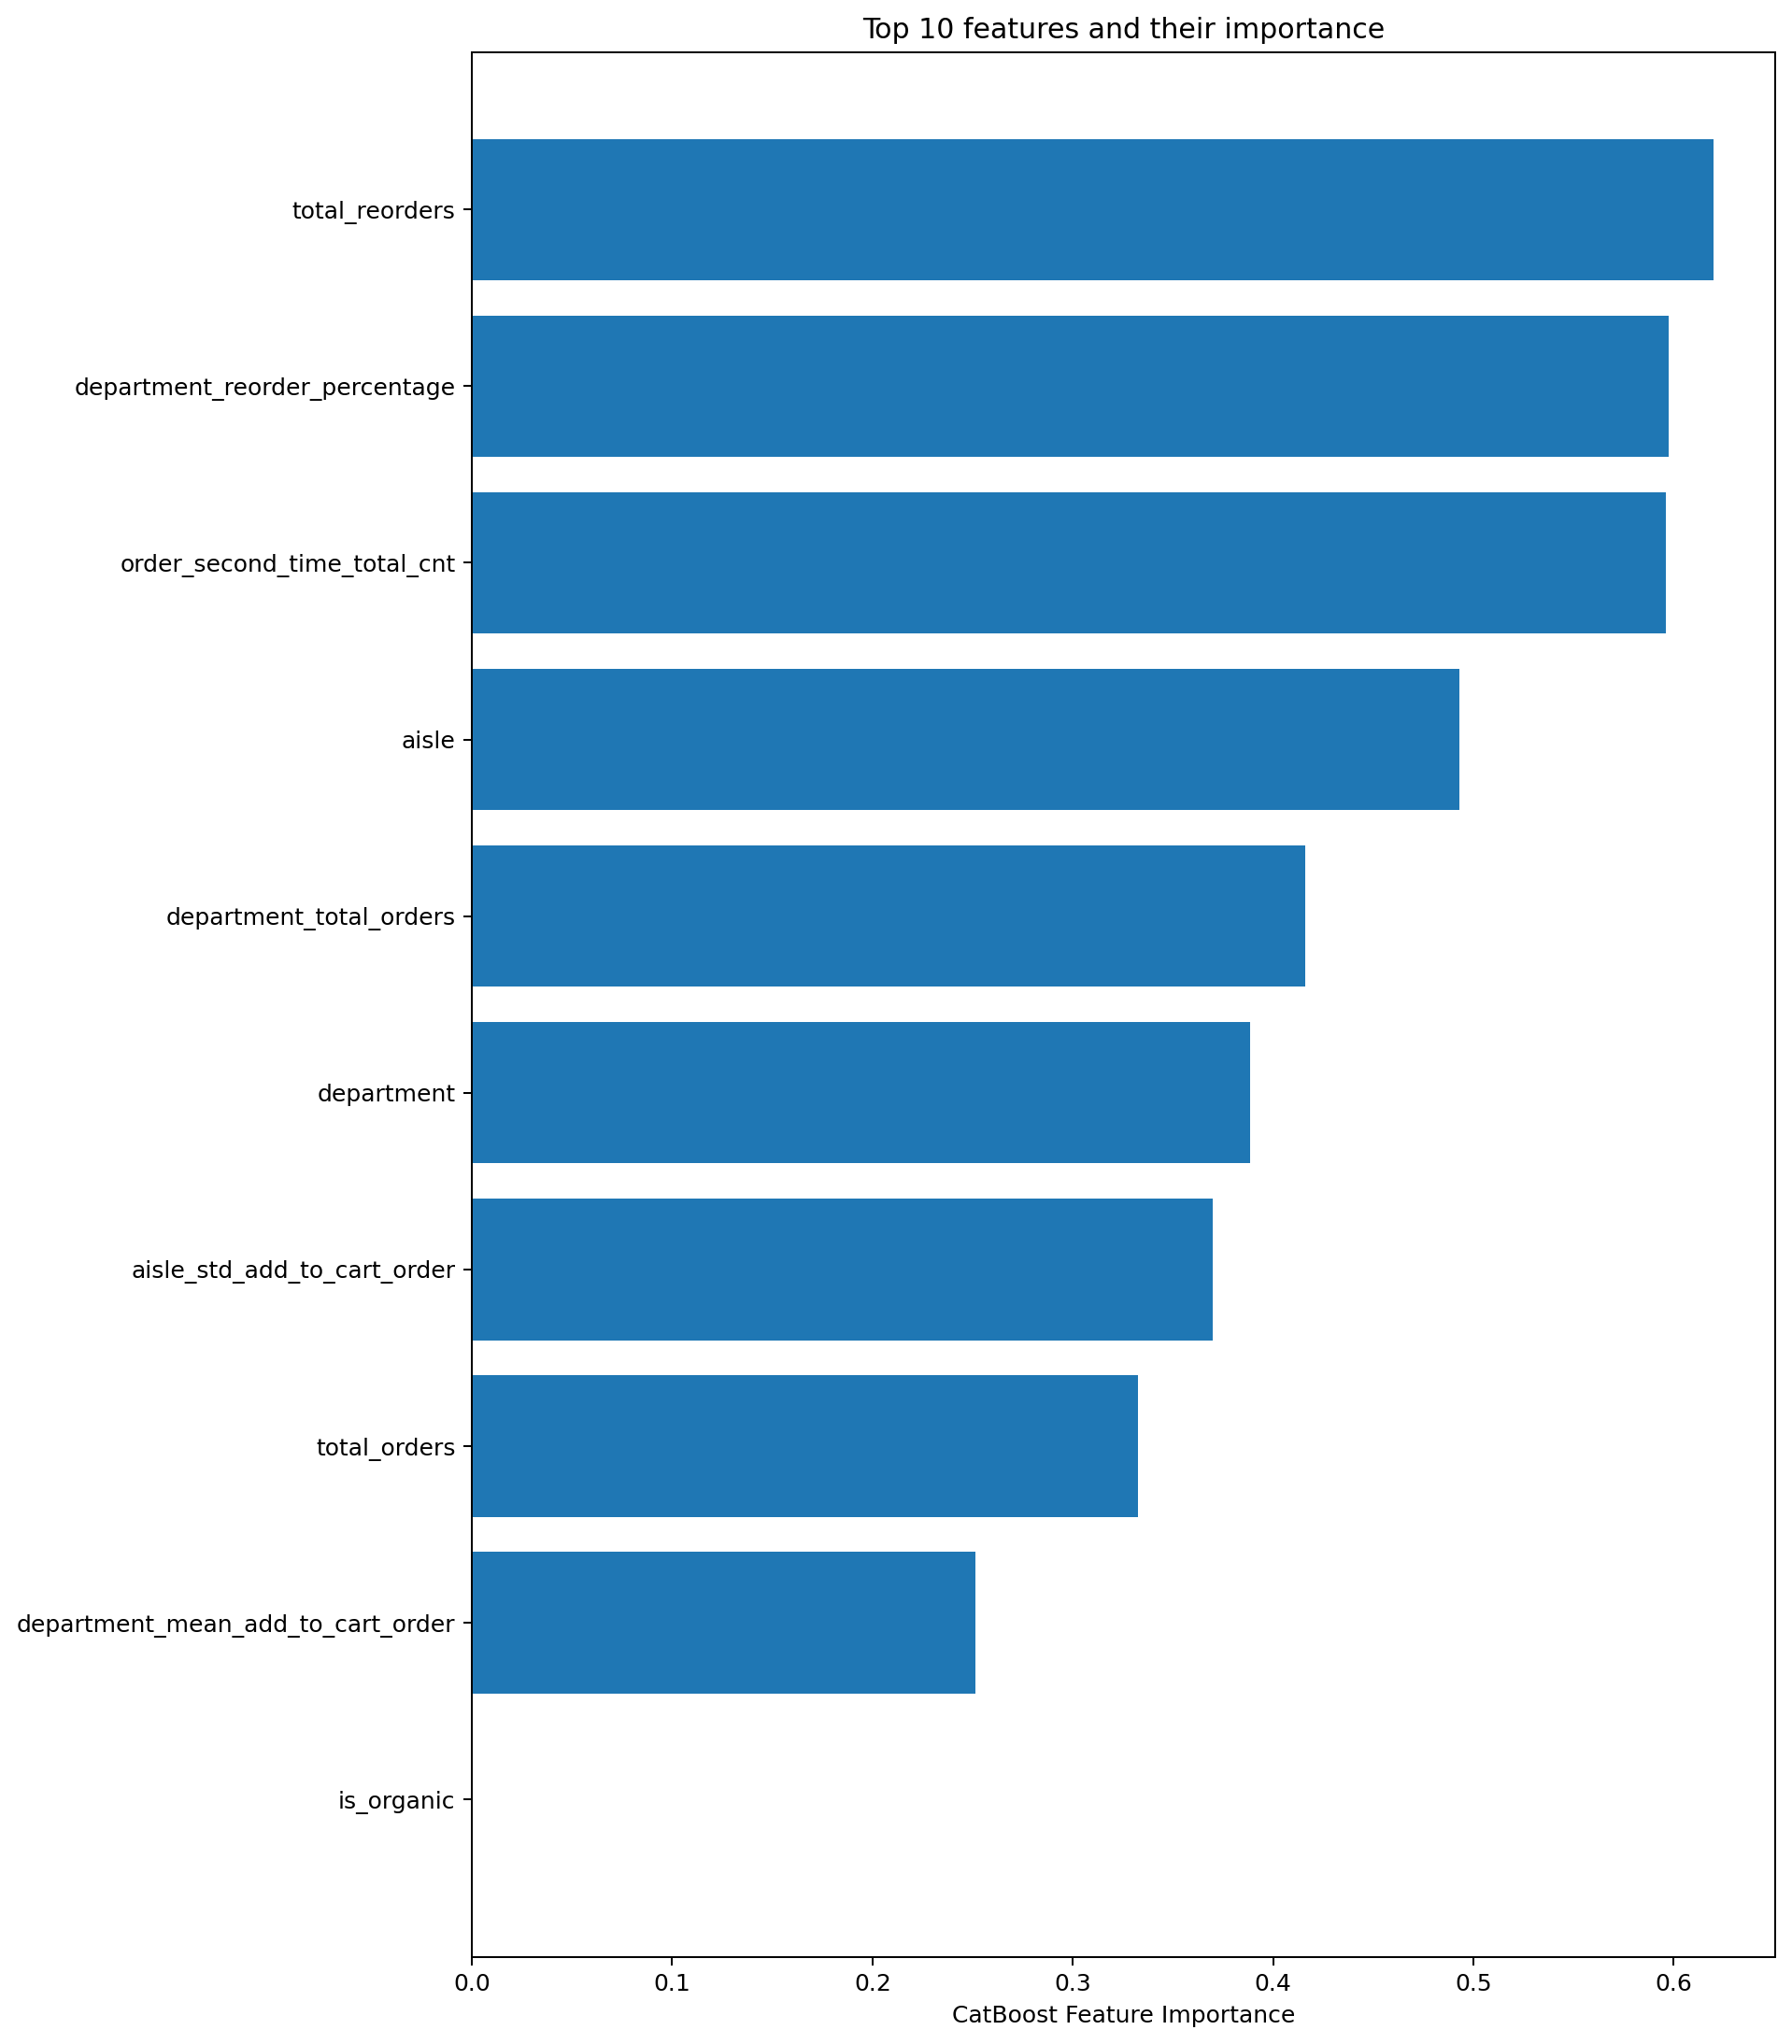

In [47]:
plot_feature_importance(catboost,top_n=10)

- **The top 10 features with the most contribution to model prediction are:**
    - total_reorders
    - department_reorder_percentage
    - order_second_time_total_cnt
    - aisle
    - department_total_order
    - department
    - aisle_std_add_to_cart_order
    - total_orders
    - department_mean_add_to_cart_order
    - is_organic